# **Sistema de Recomendación Híbrido (CF-CB)**
#### Autor: Alejandro Rodríguez Salguero


## **1.- Exploración**

Vamos a implementar un sistema de recomendación compuesto por un filtro colaborativo (CF por sus siglas en inglés *Collaborative Filtering*) y por otro componente de recomendación basada en contenido (CB, *Content-Based*). Primero haremos un análisis exploratorio de los datos.

Importamos las librerías con las que trabajaremos a lo largo de nuestro análisis del dataset:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


Carguemos nuestros datasets haciendo uso de la librería 'pandas':

In [2]:
df_movies = pd.read_csv("data/movies.csv")
df_ratings = pd.read_csv("data/ratings.csv")

Estamos en condiciones de empezar a explorar nuestros datos. Veamos las primeras 5 filas de cada uno:

In [3]:
print("-"*50)
print(df_movies.head())
print("-"*50)
print(df_ratings.head())
print("-"*50)

--------------------------------------------------
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
--------------------------------------------------
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
--------------------------------------------------


Veamos cuántos valores únicos contienen sendos dataframes para las columnas correspondientes a los usuarios y a las películas:

In [4]:
print(f"Usuarios distintos en total: {df_ratings['userId'].nunique()}")
print(f"Peliculas distintas en 'movies.csv': {df_movies['movieId'].nunique()}")
print(f"Peliculas distintas en 'ratings.csv': {df_ratings['movieId'].nunique()}\n")

Usuarios distintos en total: 610
Peliculas distintas en 'movies.csv': 9742
Peliculas distintas en 'ratings.csv': 9724



Observamos que hay 18 películas que no han sido puntuadas. Después veremos cuáles son; veamos ahora la distribución de los ratings

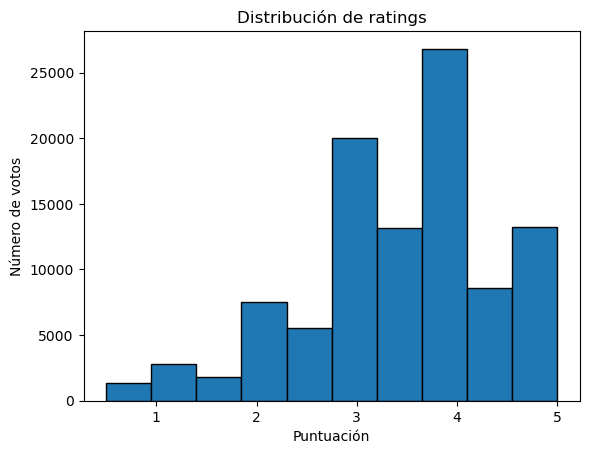

In [5]:
df_ratings["rating"].hist(bins=10, edgecolor="black")
plt.xlabel("Puntuación")
plt.ylabel("Número de votos")
plt.title("Distribución de ratings")
plt.grid(False)
plt.show()

También es interesante ver cuáles son las películas más votadas:

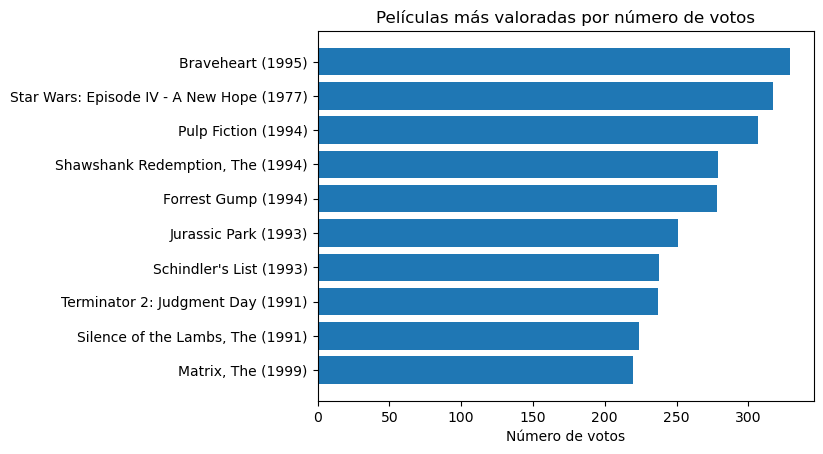

In [6]:
top_movies = df_ratings["movieId"].value_counts().head(10)
top_movies_names = df_movies[df_movies["movieId"].isin(top_movies.index)]

plt.barh(top_movies_names["title"], top_movies.values)
plt.xlabel("Número de votos")
plt.title("Películas más valoradas por número de votos")
plt.gca().invert_yaxis()
plt.show()

## **2.- Clasificación general**

Ahora, con la intención de hallar las películas mejor valoradas, vamos a calcular la puntuación media de cada película, así como el número de veces que ha sido votada (pues lógicamente no sería sensato considerar iguales a dos películas con una puntuación de 4, por ejemplo, teniendo una 300 valoraciones y la otra, tan sólo una) y guardar todo en un dataframe aparte:

In [7]:
medias = df_ratings.groupby("movieId")["rating"].mean().reset_index()
medias.columns = ["movieId", "mean_rat"]

num_rat = df_ratings.groupby("movieId")["rating"].size().reset_index()
num_rat.columns = ["movieId", "num_rat"]

df_clasif = df_movies.merge(medias, on="movieId", how="left")
df_clasif = df_clasif.merge(num_rat, on="movieId", how="left")

Veamos qué películas no tienen ninguna puntuación. Luego desecharemos tales películas ya que no tenemos información acerca de su popularidad.

In [8]:
print(df_clasif[df_clasif["num_rat"].isnull()==True]["title"])
df_clasif = df_clasif[df_clasif["num_rat"].notna()]

816                            Innocents, The (1961)
2211                                  Niagara (1953)
2499                          For All Mankind (1989)
2587    Color of Paradise, The (Rang-e khoda) (1999)
3118                  I Know Where I'm Going! (1945)
4037                              Chosen, The (1981)
4506     Road Home, The (Wo de fu qin mu qin) (1999)
4598                                  Scrooge (1970)
4704                                    Proof (1991)
5020                       Parallax View, The (1974)
5293                        This Gun for Hire (1942)
5421                    Roaring Twenties, The (1939)
5452                     Mutiny on the Bounty (1962)
5749              In the Realms of the Unreal (2004)
5824                        Twentieth Century (1934)
5837                       Call Northside 777 (1948)
5957                    Browning Version, The (1951)
7565                              Chalet Girl (2011)
Name: title, dtype: object


A continuación definimos una función para hallar la(s) película(s) mejor valorada(s) según distintos métodos, a saber: simple, ponderado y bayesiano (el más recomendado). También permite decidir el umbral mínimo de puntuaciones bajo el cuál descartaremos las películas a considerar.

In [9]:
def peliculas_mas_populares(df, genre=None, top_k=5, min_ratings=1000, metodo="bayesiano"):
    if genre == None:
        df_filtrado = df[df["num_rat"] >= min_ratings].copy()
    else:
        df_filtrado = df[df["num_rat"] >= min_ratings].copy()
        df_filtrado = df_filtrado [df_filtrado['genres'].str.contains(genero, case=False, na=False)]

    if df_filtrado.empty:
        return "No hay películas con suficientes reseñas"

    if metodo == "simple":
        df_filtrado = df_filtrado.sort_values(
            ["mean_rat", "num_rat"],
            ascending=[False, False]
        )

    elif metodo == "ponderado":
        df_filtrado["score"] = (
            0.6 * (df_filtrado["mean_rat"] / 5) +
            0.4 * (df_filtrado["num_rat"] / df_filtrado["num_rat"].max())
        )
        df_filtrado = df_filtrado.sort_values("score", ascending=False)

    elif metodo == "bayesiano":
        m = df_filtrado["mean_rat"].mean()
        C = df_filtrado["num_rat"].quantile(0.5)
        df_filtrado["score"] = (
            (C * m + df_filtrado["num_rat"] * df_filtrado["mean_rat"]) /
            (C + df_filtrado["num_rat"])
        )
        df_filtrado = df_filtrado.sort_values("score", ascending=False)

    return df_filtrado.iloc[0:top_k][["title", "genres"]]

Usamos la función que acabamos de definir para calcular las 3 películas mejor valoradas según los distintos métodos y mostramos los resultados:

In [10]:
metodos = ["simple", "ponderado", "bayesiano"]
resultados =  {}
for metodo in metodos:
    resultado = peliculas_mas_populares(df_clasif, top_k=3, min_ratings=100, metodo=metodo)
    resultados[metodo] = resultado

for metodo, resultado in resultados.items():
    print(f"{metodo.upper()}", "-"*65)
    print(f"{resultado}\n")


SIMPLE -----------------------------------------------------------------
                                 title                       genres
277   Shawshank Redemption, The (1994)                  Crime|Drama
659              Godfather, The (1972)                  Crime|Drama
2226                 Fight Club (1999)  Action|Crime|Drama|Thriller

PONDERADO -----------------------------------------------------------------
                                title                       genres
277  Shawshank Redemption, The (1994)                  Crime|Drama
314               Forrest Gump (1994)     Comedy|Drama|Romance|War
257               Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller

BAYESIANO -----------------------------------------------------------------
                                 title                       genres
277   Shawshank Redemption, The (1994)                  Crime|Drama
2226                 Fight Club (1999)  Action|Crime|Drama|Thriller
659              Godfather, T

Observamos que los tres métodos coinciden en la película más popular. Veamos cómo se desempeña filtrando por género:

In [11]:
genero = "Horror"
metodos = ["simple", "ponderado", "bayesiano"]
resultados =  {}
for metodo in metodos:
    resultado = peliculas_mas_populares(df_clasif, genero, top_k=3, min_ratings=100, metodo=metodo)
    resultados[metodo] = resultado

for metodo, resultado in resultados.items():
    print(f"{metodo.upper()}", "-"*65)
    print(f"{resultado}\n")

SIMPLE -----------------------------------------------------------------
                                title                 genres
510  Silence of the Lambs, The (1991)  Crime|Horror|Thriller
957               Shining, The (1980)                 Horror
915                      Alien (1979)          Horror|Sci-Fi

PONDERADO -----------------------------------------------------------------
                                 title                 genres
510   Silence of the Lambs, The (1991)  Crime|Horror|Thriller
2078           Sixth Sense, The (1999)   Drama|Horror|Mystery
915                       Alien (1979)          Horror|Sci-Fi

BAYESIANO -----------------------------------------------------------------
                                title                 genres
510  Silence of the Lambs, The (1991)  Crime|Horror|Thriller
957               Shining, The (1980)                 Horror
915                      Alien (1979)          Horror|Sci-Fi



## **3.- Filtrado colaborativo (CF)**

Empecemos pues con el componente CF. Dividimos nuestros datos en dos, *train* y *test* para posteriormente poder evaluar nuestro modelo. Además, usamos el método 'pivot' para obtener un dataframe cuyas filas representarán a los usuarios y sus columnas, a las películas, conteniendo los valores de las puntuaciones que cada usuario haya otorgado a cada film.

In [12]:
train, test = train_test_split(df_ratings, test_size=0.2, random_state=42)

train_pivot = train.pivot(index="userId", columns="movieId", values="rating")

Ahora centraremos nuestros datos para corregir el sesgo por usuario (puede tender a dar notas altas o bajas normalmente). Transponemos nuestro dataframe porque la función de scikit_learn considera las filas como vectores y nosotros tenemos las películas como columnas

In [13]:
user_means = train_pivot.mean(axis=1)

train_cent = train_pivot.sub(user_means, axis=0).fillna(0)
movie_user = train_cent.T

Estamos ya en disposición de usar 'cosine_similarity' para determinar películas similares según la puntuación que los usuarios les hayan dado. Ello lo conseguimos considerando cada columna formada por las puntuaciones de una película como un vector, de forma que podemos definir la similitud entre dos películas en términos del ángulo que forman entre sí los dos vectores de puntuaciones asociados: a menor ángulo, mayor verosimilitud.

Dado que el coseno es una función trigonométrica que en el intervalo de 0º a 90º es decreciente, podemos usarla para cuantificar la similitud (Podríamos implementarla nosotros mismo teniendo en cuenta la definición del coseno a partir del producto escalar: \\[ \cos \left( \theta \right) = \frac{ \overrightarrow{u} \cdot \overrightarrow{v} }{\| \overrightarrow{u}\| \| \overrightarrow{v} \|}, \quad \theta \equiv \text{ángulo entre } \overrightarrow{u} \text{ y } \overrightarrow{v} \\]

In [14]:
sim_cf = cosine_similarity(movie_user)
movie_ids = movie_user.index.to_list()
sim_cf = pd.DataFrame(sim_cf, index=movie_ids, columns=movie_ids)

Ahora vamos a aplicar la técnica de *shrinkage*, es decir, un factor de corrección que penaliza las similitudes calculadas con pocos datos, lo que ayuda a reducir el ruido (similitudes fantasmas):

In [15]:
R = train_pivot.notna().astype(int)
co_counts = R.T.dot(R)

def apply_shrinkage(sim_matrix, co_counts, k=50):
    shrink_factor = co_counts / (co_counts + k)
    return sim_matrix * shrink_factor

sim_cf_shrunk = apply_shrinkage(sim_cf, co_counts, k=50)
sim_cf_shrunk = pd.DataFrame(sim_cf, index=movie_ids, columns=movie_ids)

## **4.- Filtrado basado en contenido (CB)**

Vamos a usar el vectorizado por TF-IDF (*Term Frequency - Inverse Document Frequency*) para crear una matriz en la que cada película (filas) tendrá asociado un vector de valores formado por el producto de TF (*Term Frequency*) e IDF (*Inverse Document Frequency*). TF captura la frecuencia de un género en una película (1 ó 0 en este caso), mientras que IDF captura en cuántas películas aparece dicho género (se usa su inverso para penalizar aquellos términos que son más frecuentes pues añaden poca información).

Para empezar veamos qué géneros hay en nuestro dataset:

In [16]:
genres_expanded = df_movies.assign(genre=df_movies["genres"].str.split('|')).explode("genre")

print(genres_expanded["genre"].unique())

['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'War' 'Musical'
 'Documentary' 'IMAX' 'Western' 'Film-Noir' '(no genres listed)']


Vamos a eliminar espacios y guiones para no subdividir algunos géneros como 'Sci-Fi'. También eliminaremos los elementos *IMAX* y *(nogenrelisted)* por no aportar información sobre el género (el primero es un formato, *Image MAXimum*, y el segundo señala que no se ha asociado ningún género con tal película):

In [17]:
df_movies["genres"] = df_movies["genres"].str.replace(" ", "")
df_movies["genres"] = df_movies["genres"].str.replace("-", "")

vectorizer = TfidfVectorizer(ngram_range=(1,1),
	preprocessor=lambda x: x.replace("|", " ").lower(),
	stop_words=["nogenreslisted", "imax"])

genre_vectorization = vectorizer.fit_transform(df_movies["genres"])
print(vectorizer.get_feature_names_out())

['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'filmnoir' 'horror' 'musical' 'mystery'
 'romance' 'scifi' 'thriller' 'war' 'western']


Veamos una nube de géneros:

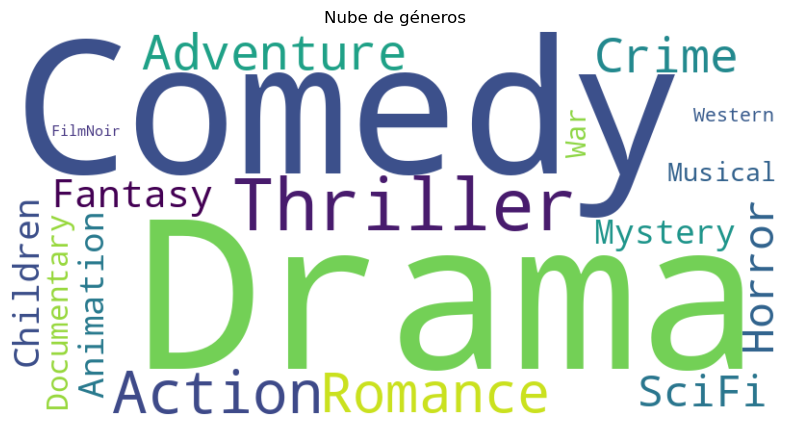

In [18]:
text = " ".join(df_movies["genres"].str.replace("|", " "))
stop_words = ["nogenreslisted", "imax"] + list(STOPWORDS)
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stop_words, collocations=False).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de géneros")
plt.show()

Usamos de nuevo 'cosine_similarity' para cuantificar la similitud entre las películas, aunque en este caso lo hacemos en función de sus géneros. Crearemos un dataframe donde el elemento de la fila *i* y columna *j* representará la similitud entre la película con ID *i* y la película con ID *j*.

In [19]:
sim_cb = cosine_similarity(genre_vectorization)
sim_cb = pd.DataFrame(sim_cb, index=df_movies["movieId"], columns=df_movies["movieId"])

## **5.- Hibridación**

Construimos un dataframe que almacene la similitud resultante de la suma ponderada de las similitudes producidas por nuestros componentes CF y CB:

In [20]:
alpha = 0.7
sim_hybrid = alpha * sim_cf.reindex(index=movie_ids, columns=movie_ids).fillna(0) \
            + (1 - alpha) * sim_cb.reindex(index=movie_ids, columns=movie_ids).fillna(0)
sim_hybrid_shrunk = alpha * sim_cf_shrunk.reindex(index=movie_ids, columns=movie_ids).fillna(0) \
            + (1 - alpha) * sim_cb.reindex(index=movie_ids, columns=movie_ids).fillna(0)

## **6.- Evaluación del modelo**

Usaremos para evaluar nuestro modelo una métrica general como el RMSE (*Root Mean Squared Error*) y otra específica para la relevancia de rankings que es *Precision@K* (evalúa el Top K recomendaciones por usuario).

Primero creamos una función auxiliar que genere una predicción sobre una película concreta para un usuario dado. Luego en la siguiente función calcularemos el RMSE sobre los elementos del sunconjunto de los datos *test* usando la matriz de similitudes proporcionada. Podemos ver las diferencias entre el filtrado colaborativo, el filtrado basado en contenido y el filtrado híbrido.

In [21]:
def predict_rating_item_item(user_id, movie_id, sim_matrix, train_matrix):
    if movie_id not in sim_matrix.index:
        if user_id in train_matrix.index:
            return train_matrix.loc[user_id].mean()
        else:
            return train_matrix.stack().mean()

    user_ratings = train_matrix.loc[user_id].dropna() if user_id in train_matrix.index else pd.Series(dtype=float)
    if user_ratings.empty:
        return train_matrix.stack().mean()

    sims = sim_matrix.loc[movie_id, user_ratings.index].astype(float)
    numer = (sims * user_ratings).sum()
    denom = sims.abs().sum()
    if denom == 0:
        return user_ratings.mean() if not user_ratings.empty else train_matrix.stack().mean()
    return numer / denom

def rmse_on_test(sim_matrix):
    y_true, y_pred = [], []
    for _, row in test.iterrows():
        u = row['userId']; i = row['movieId']; r = row['rating']
        pred = predict_rating_item_item(u, i, sim_matrix, train_pivot)
        y_true.append(r); y_pred.append(pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_cf = rmse_on_test(sim_cf)
rmse_cb = rmse_on_test(sim_cb)
rmse_hybrid = rmse_on_test(sim_hybrid)

print(f"RMSE CF: {rmse_cf:.4f}")
print(f"RMSE CB: {rmse_cb:.4f}")
print(f"RMSE Hybrid: {rmse_hybrid:.4f}")

RMSE CF: 3.0399
RMSE CB: 0.9222
RMSE Hybrid: 1.1720


Veamos la diferencia incorporando el *shrinkage*:

In [22]:
rmse_cf_shrunk = rmse_on_test(sim_cf_shrunk)
rmse_hybrid_shrunk = rmse_on_test(sim_hybrid_shrunk)

print(f"RMSE CF (shrunk): {rmse_cf_shrunk:.4f}")
print(f"RMSE Hybrid (shrunk): {rmse_hybrid_shrunk:.4f}")

RMSE CF (shrunk): 3.0399
RMSE Hybrid (shrunk): 1.1720


Para *Precision@K* no vamos a inspeccionar todas las similitudes posibles con sus películas vistas para no demorar el tiempo de cómputo a horas. En su lugar consideraremos sólo las 100 películas más similares a cada una de las que haya visto. Para ello primero construimos una función que nos permita encontrar a las mismas:

In [23]:
def build_top_neighbors(sim_matrix, topn=100):
    neighbors = {}
    for item in sim_matrix.index:
        sims = sim_matrix.loc[item].drop(item)
        top_neighbors = sims.nlargest(topn).index.to_list()
        neighbors[item] = top_neighbors
    return neighbors

Ya podemos construir la función auxiliar que nos proporcione las *k* mejores recomendaciones para un usuario dado de forma que luego podamos usarla para calcular la métrica *Precision@K* en la siguiente función sobre el subconjunto de los datos *test*.

In [24]:
def recommend_for_user(user_id, train_matrix, sim_matrix, top_neighbors, k=10):
    if user_id not in train_matrix.index:
        return []

    user_ratings = train_matrix.loc[user_id].dropna()
    if user_ratings.empty:
        return []

    scores = {}
    for item_rated, rating in user_ratings.items():
        for neighbor in top_neighbors.get(item_rated, []):
            if neighbor in user_ratings.index:
                continue  # ya lo vio
            sim = sim_matrix.loc[item_rated, neighbor]
            scores[neighbor] = scores.get(neighbor, 0) + sim*rating

    top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]
    return [item for item, _ in top_items]

def precision_at_k(train, test, train_matrix, sim_matrix, k=10, threshold=4.0, topn_neighbors=100):
    top_neighbors = build_top_neighbors(sim_matrix, topn=topn_neighbors)

    test_rel = test[test['rating'] >= threshold].groupby('userId')['movieId'].apply(set).to_dict()

    precisions = []
    for user in train['userId'].unique():
        top_k = recommend_for_user(user, train_matrix, sim_matrix, top_neighbors, k=k)
        if not top_k:
            continue
        relevant = test_rel.get(user, set())
        prec = len(set(top_k) & relevant) / k
        precisions.append(prec)

    return np.mean(precisions) if precisions else 0.0

prec_cf = precision_at_k(train, test, train_pivot, sim_cf, k=10)
prec_cb = precision_at_k(train, test, train_pivot, sim_cb, k=10)
prec_hybrid = precision_at_k(train, test, train_pivot, sim_hybrid, k=10)

print(f"Precision@10 CF: {prec_cf:.4f}")
print(f"Precision@10 CB: {prec_cb:.4f}")
print(f"Precision@10 Hybrid: {prec_hybrid:.4f}")


Precision@10 CF: 0.0436
Precision@10 CB: 0.0185
Precision@10 Hybrid: 0.0607


El sistema item-item con *cosine_similarity* obtiene Precision@10 ≈ 0.04. Aunque bajo, es mejor que el método basado en contenido (≈0.018), y se mejora ligeramente al usar un modelo híbrido (≈0.06). Vemos que la combinación de CF y CB es beneficiosa (en producción se usarían técnicas vectorizadas para escalar el cálculo, aquí mostramos una versión simplificada para claridad). Veamos al incorporar el *shrinkage*:

In [25]:
prec_cf_shrunk = precision_at_k(train, test, train_pivot, sim_cf_shrunk, k=10)
prec_hybrid_shrunk = precision_at_k(train, test, train_pivot, sim_hybrid_shrunk, k=10)

print(f"Precision@10 CF (shrunk): {prec_cf_shrunk:.4f}")
print(f"Precision@10 Hybrid (shrunk): {prec_hybrid_shrunk:.4f}")

Precision@10 CF (shrunk): 0.0436
Precision@10 Hybrid (shrunk): 0.0607


Claramente el modelo mejora incorporando el factor *shrinkage*.

In [26]:
sim_cf = sim_cf_shrunk
sim_hybrid = sim_hybrid_shrunk

## **7.- Para poder usar el modelo**

Finalmente construimos un par de funciones para poner en práctica nuestro sistema de recomendación híbrido: una que nos devolverá las *k* películas más similares a aquella cuyo título le proporcionemos, y otra que nos devolverá las *k* mejores recomendaciones para un usuario dado según sus valoraciones superiores a cierto valor umbral (básicamente prepara de forma inteligible los resultados de la que ya teníamos para ello).

In [27]:
def get_similar_movies(title, k=10):
    movieId = df_movies[df_movies["title"] == title]["movieId"].values[0]
    similarity = sim_hybrid[movieId]

    top_k = similarity.sort_values(ascending=False).head(k+1).iloc[1:]

    list_movies = []
    for id in top_k.index:
        row = df_movies[df_movies["movieId"] == id][["title", "genres"]].values[0]
        sim = top_k[id]
        list_movies.append([row[0], row[1], sim])
    
    return list_movies

def user_recommendations(user_id, train, train_matrix, sim_matrix, top_neighbors, k=5, threshold=4.0):
    liked = train[(train["userId"]==user_id) & (train["rating"] >= threshold)]
    liked = liked.merge(df_movies, on="movieId")[["title", "rating"]]

    rec_ids = recommend_for_user(user_id, train_matrix, sim_matrix, top_neighbors, k)
    recs = df_movies[df_movies["movieId"].isin(rec_ids)][["movieId", "title"]]

    return liked, recs

## **8.- Ejemplos**

Ya hemos visto que podemos encontrar las películas mejor valoradas globalmente y por género. Veamos ahora algunos ejemplos de las últimas funciones que hemos construido:

### **8.1.- Recomendaciones para un usuario concreto:**

In [28]:
liked, recs = user_recommendations(
    user_id=61,
    train=train,
    train_matrix=train_pivot,
    sim_matrix=sim_hybrid,
    top_neighbors=build_top_neighbors(sim_hybrid, topn=100),
    k=5,
    threshold=4.5
)

print("Películas que el usuario valoró alto:")
print(liked)

print("\nRecomendaciones generadas:")
print(recs)

Películas que el usuario valoró alto:
                                               title  rating
0                                     Gattaca (1997)     4.5
1          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)     4.5
2  Good, the Bad and the Ugly, The (Buono, il bru...     4.5
3                                     Memento (2000)     4.5
4                   Shawshank Redemption, The (1994)     5.0
5                                      Snatch (2000)     4.5
6                              Reservoir Dogs (1992)     4.5
7                                       Alien (1979)     4.5
8  Léon: The Professional (a.k.a. The Professiona...     4.5
9                              Apocalypse Now (1979)     4.5

Recomendaciones generadas:
      movieId                        title
257       296          Pulp Fiction (1994)
907      1206   Clockwork Orange, A (1971)
2226     2959            Fight Club (1999)
2462     3275  Boondock Saints, The (2000)
6315    48516         Departed, The (2006)


### **8.2.- Películas similares a una concreta:**

- #### **Toy Story**

In [29]:
example1 = get_similar_movies(title="Toy Story (1995)", k=3)

for i in range(len(example1)):
    print(f"Película: {example1[i][0]}\nGéneros: {example1[i][1]}\nSimilitud: {example1[i][2]*100:.1f}%\n\n")

Película: Toy Story 2 (1999)
Géneros: Adventure|Animation|Children|Comedy|Fantasy
Similitud: 51.5%


Película: Toy Story 3 (2010)
Géneros: Adventure|Animation|Children|Comedy|Fantasy|IMAX
Similitud: 49.7%


Película: Finding Nemo (2003)
Géneros: Adventure|Animation|Children|Comedy
Similitud: 45.6%




- #### **Cadena perpetua**

In [30]:
example2 = get_similar_movies(title="Shawshank Redemption, The (1994)", k=3)

for i in range(len(example2)):
    print(f"Película: {example2[i][0]}\nGéneros: {example2[i][1]}\nSimilitud: {example2[i][2]*100:.1f}%\n\n")

Película: Green Mile, The (1999)
Géneros: Crime|Drama
Similitud: 48.0%


Película: American History X (1998)
Géneros: Crime|Drama
Similitud: 47.5%


Película: Goodfellas (1990)
Géneros: Crime|Drama
Similitud: 47.5%




- #### **Pulp fiction**

In [31]:
example3 = get_similar_movies(title="Pulp Fiction (1994)", k=3)

for i in range(len(example3)):
    print(f"Película: {example3[i][0]}\nGéneros: {example3[i][1]}\nSimilitud: {example3[i][2]*100:.1f}%\n\n")

Película: Fight Club (1999)
Géneros: Action|Crime|Drama|Thriller
Similitud: 50.9%


Película: Taxi Driver (1976)
Géneros: Crime|Drama|Thriller
Similitud: 45.4%


Película: Usual Suspects, The (1995)
Géneros: Crime|Mystery|Thriller
Similitud: 45.2%




- #### **El padrino**

In [32]:
example4 = get_similar_movies(title="Godfather, The (1972)", k=3)

for i in range(len(example4)):
    print(f"Película: {example4[i][0]}\nGéneros: {example4[i][1]}\nSimilitud: {example4[i][2]*100:.1f}%\n\n")

Película: Godfather: Part II, The (1974)
Géneros: Crime|Drama
Similitud: 71.4%


Película: Goodfellas (1990)
Géneros: Crime|Drama
Similitud: 61.4%


Película: 25th Hour (2002)
Géneros: Crime|Drama
Similitud: 47.4%




## **9.- Exportar datos para Tableau**
En esta sección guardamos ciertos resúmenes en formato CSV con el fin de construir dashboards interactivos en Tableau Public.

- **Distribución de ratings:**

In [33]:
ratings_dist = df_ratings['rating'].value_counts().sort_index()
ratings_dist.to_csv("exports/ratings_distribution.csv", header=True)

- **Número de votos por película:**

In [34]:
movie_votes = df_ratings['movieId'].value_counts().reset_index()
movie_votes.columns = ['movieId', 'num_votes']
movie_votes = movie_votes.merge(df_movies[['movieId', 'title']], on='movieId', how='left')
movie_votes.to_csv("exports/movie_votes.csv", index=False)

- **Media de rating por género:**

In [35]:
genres_expanded = genres_expanded.drop(genres_expanded[genres_expanded["genre"] == "IMAX"].index)
genres_expanded = genres_expanded.drop(genres_expanded[genres_expanded["genre"] == "(nogenreslisted)"].index)

avg_rating_genre = df_ratings.merge(genres_expanded, on='movieId') \
    .groupby('genre')['rating'].mean().reset_index()
avg_rating_genre.to_csv("exports/avg_rating_per_genre.csv", index=False)

- **Matriz de similitud:**

In [36]:
top_similarities = []
for movie_id in sim_hybrid.index:
    sims = sim_hybrid.loc[movie_id].drop(movie_id).nlargest(5)  # top 5
    for other_id, sim in sims.items():
        top_similarities.append([movie_id, other_id, sim])

df_top_sims = pd.DataFrame(top_similarities, columns=['movieId', 'similar_movieId', 'similarity'])
df_top_sims = df_top_sims.merge(df_movies[['movieId', 'title']], on='movieId') \
                         .merge(df_movies[['movieId', 'title']], left_on='similar_movieId', right_on='movieId',
                                suffixes=('_main', '_similar'))[['title_main', 'title_similar', 'similarity']]

df_top_sims.to_csv("exports/top_movie_similarities.csv", index=False)

- **Usuarios activos:**

In [37]:
user_activity = df_ratings['userId'].value_counts().reset_index()
user_activity.columns = ['userId', 'num_ratings']
user_activity.to_csv("exports/user_activity.csv", index=False)

- **Resultados de evaluación:**

In [38]:
metrics = {
    "model": ["Collaborative Filtering", "Collaborative Filtering (shrunk)", "Content-Based", "Hybrid", "Hybrid (shrunk)"],
    "precision_at_10": [prec_cf, prec_cf_shrunk, prec_cb, prec_hybrid, prec_hybrid_shrunk]  # tus valores reales
}
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv("exports/model_performance.csv", index=False)

## **10.- Agradecimientos**

Este proyecto utiliza el conjunto de datos [MovieLens Latest Small](https://grouplens.org/datasets/movielens/latest/) proporcionado por 
[GroupLens Research](https://grouplens.org/) en la Universidad de Minnesota.

Los datos son de uso libre para investigación y docencia bajo su licencia de uso, 
y se agradece citar a los autores originales:

> Harper, F. Maxwell and Konstan, Joseph A. (2015). 
> *The MovieLens Datasets: History and Context*. 
> ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19.
